#### References

1.https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/

2.https://www.kaggle.com/maksimeren/covid-19-literature-clustering/

3.https://www.kaggle.com/headsortails/explorations-of-action-moa-eda/

In this kernel,I have done a basic exploratory data analysis of the MOA datasets.In most of the sections,I have borrowed ideas from [Head's or Tails EDA](https://www.kaggle.com/headsortails/explorations-of-action-moa-eda) kernel and tried to reproduce the same in python.

#### Whats different ?
* Tried to deep dive into the target column names.
* Done clustering,t-SNE of gene expressions to identify if there is any pattern.

If there is any mistake in any of my interpretation,pls let me know in the comments section.Thanks.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv


In [2]:
df_train=pd.read_csv("../input/lish-moa/train_targets_scored.csv")
df_train_nonscored=pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
train_features=pd.read_csv("../input/lish-moa/train_features.csv")
test_features=pd.read_csv("../input/lish-moa/test_features.csv")

In [3]:
df_train.shape,df_train_nonscored.shape,train_features.shape,test_features.shape

((23814, 207), (23814, 403), (23814, 876), (3982, 876))

In [4]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


Here g-* signifies gene expression data and c-* signifies cell viability.

gene expression - Gene expression is the process by which the information encoded in a gene is used to direct the assembly of a protein molecule. The cell reads the sequence of the gene in groups of three bases.

cell viability- Cell viability is a measure of the proportion of live, healthy cells within a population. Cell viability assays are used to determine the overall health of cells, optimize culture or experimental conditions, and to measure cell survival following treatment with compounds, such as during a drug screen.


In [5]:
train_features['cp_type'].value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

trt_cp -Compound treatment - A compound treatment study design type is where the response to administration of a compound or chemical (including biological compounds such as hormones) is assayed.

ctl_vehicle - control perturbation . This does not have MOA's.

In [6]:
train_features['cp_time'].value_counts()

48    8250
72    7792
24    7772
Name: cp_time, dtype: int64

There are three treatment durations - 24 hrs,48 hrs and 72 hrs.

In [7]:
train_features['cp_dose'].value_counts()

D1    12147
D2    11667
Name: cp_dose, dtype: int64

This is the dosage of the drug.-High or low.It is not very clear as to which one is high or which one is low.

In [8]:
gene_expressions=train_features.columns.str.startswith('g-')
sum(gene_expressions)

772

Text(0.5, 0, 'Std of gene expression')

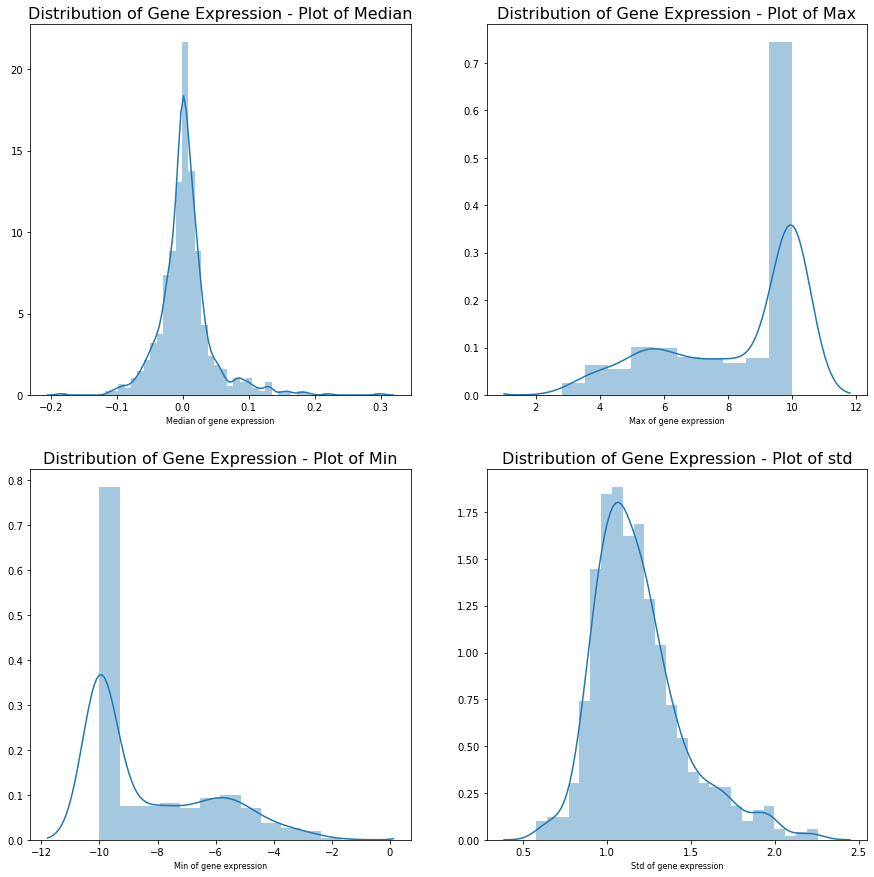

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.distplot(train_features.loc[:,gene_expressions].median())
plt.title("Distribution of Gene Expression - Plot of Median",fontsize=16)
plt.xlabel("Median of gene expression",fontsize=8)
plt.subplot(2,2,2)
sns.distplot(train_features.loc[:,gene_expressions].max())
plt.title("Distribution of Gene Expression - Plot of Max",fontsize=16)
plt.xlabel("Max of gene expression",fontsize=8)
plt.subplot(2,2,3)
sns.distplot(train_features.loc[:,gene_expressions].min())
plt.title("Distribution of Gene Expression - Plot of Min",fontsize=16)
plt.xlabel("Min of gene expression",fontsize=8)
plt.subplot(2,2,4)
sns.distplot(train_features.loc[:,gene_expressions].std())
plt.title("Distribution of Gene Expression - Plot of std",fontsize=16)
plt.xlabel("Std of gene expression",fontsize=8)

In [10]:
cell_viability=train_features.columns.str.startswith('c-')
sum(cell_viability)

100

772 gene expression features and 100 cell viability features.

Text(0.5, 0, 'Std of Cell Viability')

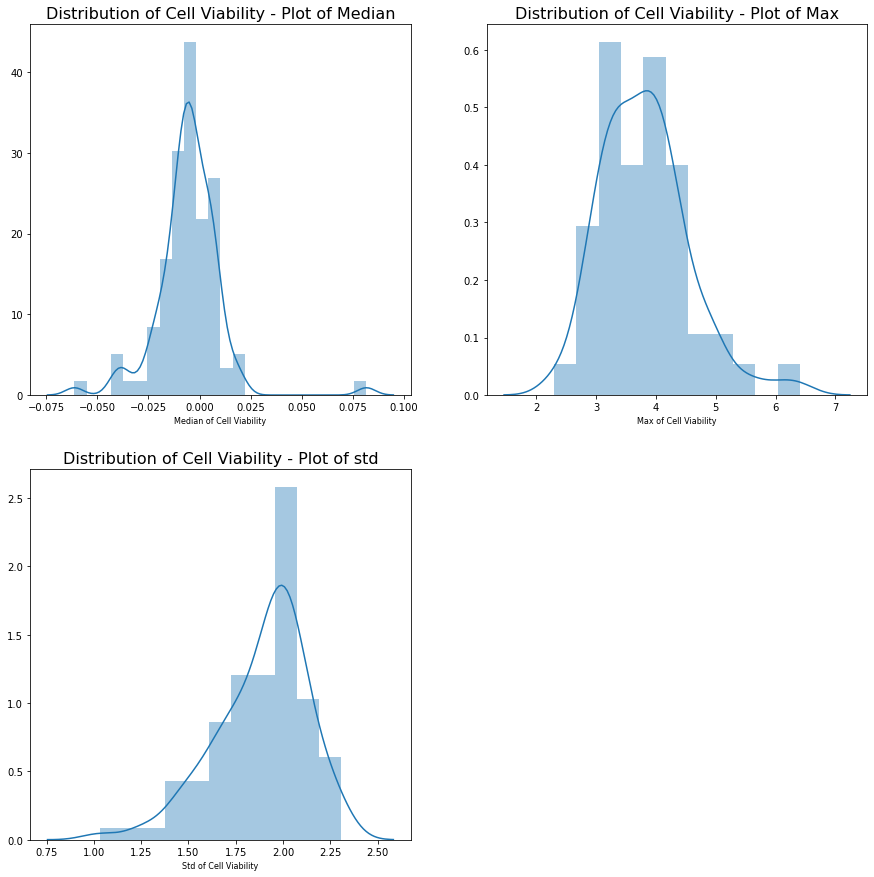

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.distplot(train_features.loc[:,cell_viability].median())
plt.title("Distribution of Cell Viability - Plot of Median",fontsize=16)
plt.xlabel("Median of Cell Viability",fontsize=8)
plt.subplot(2,2,2)
sns.distplot(train_features.loc[:,cell_viability].max())
plt.title("Distribution of Cell Viability - Plot of Max",fontsize=16)
plt.xlabel("Max of Cell Viability",fontsize=8)
#plt.subplot(2,2,3)
# sns.distplot(train_features.loc[:,cell_viability].min())
# plt.title("Distribution of Cell Viability - Plot of Min",fontsize=16)
# plt.xlabel("Min of Cell Viability",fontsize=8)
plt.subplot(2,2,3)
sns.distplot(train_features.loc[:,cell_viability].std())
plt.title("Distribution of Cell Viability - Plot of std",fontsize=16)
plt.xlabel("Std of Cell Viability",fontsize=8)

In [12]:
train_features.loc[:,cell_viability].min().value_counts()

-10.000    95
-8.414      1
-6.452      1
-9.839      1
-9.938      1
-9.910      1
dtype: int64

* Cell viability min value is around -10  for almost all of the cell viability columns.
* Max values are between 3 to 4.It is multimodal.
* Standard deviation peaks at 2.
* From the above stats,we can understand that each individual cell viabilities if plotted could form a bell shaped curve.Lets take a random cell viability column and plot the same.

Text(0.5, 0, 'Cell Viability')

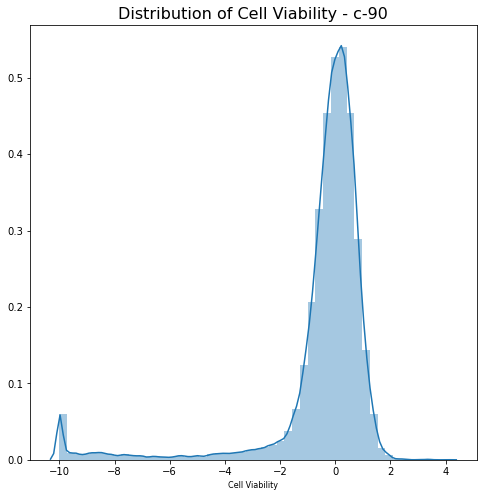

In [13]:
plt.figure(figsize=(8,8))
sns.distplot(train_features.loc[:,'c-90'])
plt.title("Distribution of Cell Viability - c-90",fontsize=16)
plt.xlabel("Cell Viability",fontsize=8)

### Exploring the class names 

In [14]:
df_train.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This data provides the class labels we need to predict.Lets check for which target classes are there most active MOA's.Before that lets inspect the column names based on the input from [Andrea Zaliani](https://www.kaggle.com/headsortails/explorations-of-action-moa-eda/comments)'s comments in Head's or Tails kernel.

Class names can be receptors or enzymes both are proteins.
 
* Receptors - Targets lying on the surface.They can be modulated positively by agonists and negatively by antagonists.

* Enzymes - Targets lying within the cells.They can be modulated positively by activators and negatively by inhibitors or blockers.

* Agents - Modulators.


In [15]:
target_sums=df_train.iloc[:,1:].sum(axis=0)

Agent class names,

In [16]:
## Agents class names,
print('Total Agent classes',len(target_sums.loc[target_sums.index.str.contains('_agent')]))
print('Agent class names & total active MOA for each class')
print(target_sums.loc[target_sums.index.str.contains('_agent')])

Total Agent classes 3
Agent class names & total active MOA for each class
chelating_agent         54
dna_alkylating_agent    48
mucolytic_agent         48
dtype: int64


Receptor class names,

In [17]:
## Receptors class names,
print('Total Receptors',len(target_sums.loc[target_sums.index.str.contains('_agonist')])+len(target_sums.loc[target_sums.index.str.contains('_antagonist')]))
# print('Agonist class names & total active MOA for each class')
# print(target_sums.loc[target_sums.index.str.contains('_agonist')])
# print('Antagonist class names & total active MOA for each class')
# print(target_sums.loc[target_sums.index.str.contains('_antagonist')])

Total Receptors 60


In [18]:
## Enzymes class names,
print('Total Enzymes class names',len(target_sums.loc[target_sums.index.str.contains('_inhibitor')])+len(target_sums.loc[target_sums.index.str.contains('_activator')])+len(target_sums.loc[target_sums.index.str.contains('_blocker')]))

Total Enzymes class names 119


In [19]:
# print('Inhibitor class names & total active MOA for each class')
# print(target_sums.loc[target_sums.index.str.contains('_inhibitor')])
# print('Activator class names & total active MOA for each class')
# print(target_sums.loc[target_sums.index.str.contains('_activator')])
# print('Blocker class names & total active MOA for each class')
# print(target_sums.loc[target_sums.index.str.contains('_blocker')])

In [20]:
#Other class names,
print("Total Other class names",len(target_sums.loc[~((target_sums.index.str.contains('_agent')) | 
                  (target_sums.index.str.contains('_inhibitor')) |
                  (target_sums.index.str.contains('_agonist')) | 
                  (target_sums.index.str.contains('_antagonist') | 
                   (target_sums.index.str.contains('_activator') |
                    (target_sums.index.str.contains('_blocker')))))]))
print(target_sums.loc[~((target_sums.index.str.contains('_agent')) | 
                  (target_sums.index.str.contains('_inhibitor')) |
                  (target_sums.index.str.contains('_agonist')) | 
                  (target_sums.index.str.contains('_antagonist') | 
                   (target_sums.index.str.contains('_activator') |
                    (target_sums.index.str.contains('_blocker')))))])

Total Other class names 24
analgesic                 12
anesthetic_-_local        80
anti-inflammatory         73
antiarrhythmic             6
antibiotic                43
anticonvulsant            12
antifungal                13
antihistamine             12
antimalarial              18
antioxidant               73
antiprotozoal             36
antiviral                 23
apoptosis_stimulant       49
bacterial_antifolate      36
diuretic                   6
free_radical_scavenger    18
immunosuppressant         73
insulin_secretagogue      30
insulin_sensitizer        51
laxative                   6
nitric_oxide_donor        26
radiopaque_medium         56
steroid                    6
vitamin_b                 26
dtype: int64


In [21]:
print(f'''Percentage of inhibitors present {(target_sums[target_sums.index.str.contains('_inhibitor')].count()/206)*100:.2f} %''')
print(f'''Percentage of antagonist present {(target_sums[target_sums.index.str.contains('_antagonist')].count()/206)*100:.2f} %''')
print(f'''Percentage of agonist present {(target_sums[target_sums.index.str.contains('_agonist')].count()/206)*100:.2f} %''')

Percentage of inhibitors present 54.37 %
Percentage of antagonist present 15.53 %
Percentage of agonist present 13.59 %


In [22]:
#Counter([i[-1] for i in target_sums.index.str.split("_")])

Now that we have checked on the class names,lets see which classes have most and least active MOA.

In [23]:
df_train.loc[:,target_sums.sort_values(ascending=False).head(5).index].sum(axis=0)

nfkb_inhibitor                   832
proteasome_inhibitor             726
cyclooxygenase_inhibitor         435
dopamine_receptor_antagonist     424
serotonin_receptor_antagonist    404
dtype: int64

In [24]:
df_train.loc[:,target_sums.sort_values(ascending=False).tail(5).index].sum(axis=0)

protein_phosphatase_inhibitor                 6
autotaxin_inhibitor                           6
diuretic                                      6
erbb2_inhibitor                               1
atp-sensitive_potassium_channel_antagonist    1
dtype: int64

In [25]:
df_train.loc[:,target_sums.sort_values(ascending=False).tail(10).index].sum(axis=0)

calcineurin_inhibitor                         6
atm_kinase_inhibitor                          6
nicotinic_receptor_agonist                    6
retinoid_receptor_antagonist                  6
antiarrhythmic                                6
protein_phosphatase_inhibitor                 6
autotaxin_inhibitor                           6
diuretic                                      6
erbb2_inhibitor                               1
atp-sensitive_potassium_channel_antagonist    1
dtype: int64

There is a small difference between my results and Head's or Tails.A closer look at this will reveal that there are many target classes with activations of 6 and hence the classes in Head's or Tails kernel match with my results.

It is seen from the top and bottom frequency target classes that most of them are inhibitor,agonist,antagonist.Lets do a quick check of what percentage of these class names are common.

Lets check how many target classes are active at once.

Text(0.5, 0, 'Label Count')

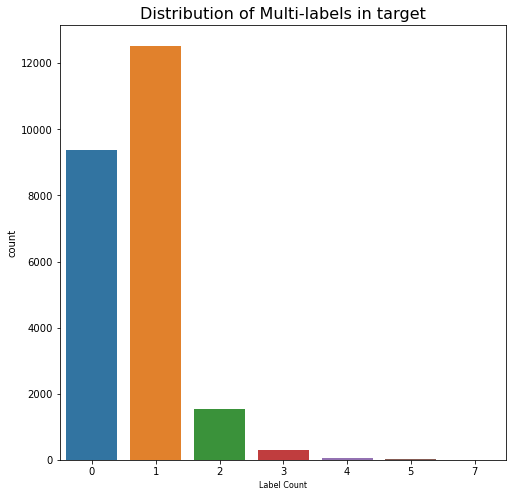

In [26]:
plt.figure(figsize=(8,8))
sns.countplot(df_train.iloc[:,1:].sum(axis=1))
plt.title("Distribution of Multi-labels in target",fontsize=16)
plt.xlabel("Label Count",fontsize=8)

In [27]:
target_stat=df_train.iloc[:,1:].sum(axis=1).reset_index(drop=True)
(target_stat.value_counts()/target_stat.shape[0])*100

1    52.624507
0    39.334005
2     6.458386
3     1.272361
4     0.230957
5     0.054590
7     0.025195
dtype: float64

In [28]:
target_stat.value_counts()

1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
dtype: int64

39 % of the sig_ids do not have any MOA's whereas 52 % have 1 MOA.Less than 0.5 % of the sig_ids have more than 4 MOA's.

In [29]:
single_moa=df_train.loc[(df_train.iloc[:,1:].sum(axis=1))==1]

In [30]:
(single_moa.iloc[:,1:].idxmax(axis=1).value_counts()/12532)*100

cyclooxygenase_inhibitor                      2.984360
glutamate_receptor_antagonist                 2.689116
adrenergic_receptor_antagonist                2.673157
dna_inhibitor                                 2.633259
cdk_inhibitor                                 2.521545
                                                ...   
caspase_activator                             0.047877
tropomyosin_receptor_kinase_inhibitor         0.047877
nicotinic_receptor_agonist                    0.047877
retinoid_receptor_antagonist                  0.047877
atp-sensitive_potassium_channel_antagonist    0.007980
Length: 203, dtype: float64

In [31]:
len(df_train.loc[(df_train.iloc[:,1:].sum(axis=1))==1])

12532

### Non scored train dataset

In [32]:
df_train_nonscored.head()

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Label Count')

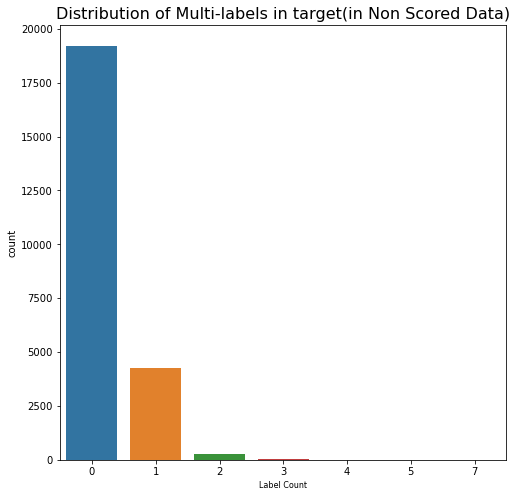

In [33]:
plt.figure(figsize=(8,8))
sns.countplot(df_train_nonscored.iloc[:,1:].sum(axis=1))
plt.title("Distribution of Multi-labels in target(in Non Scored Data)",fontsize=16)
plt.xlabel("Label Count",fontsize=8)

In [34]:
target_nonsco_stat=df_train_nonscored.iloc[:,1:].sum(axis=1).reset_index(drop=True)
(target_nonsco_stat.value_counts()/target_nonsco_stat.shape[0])*100

0    80.725624
1    17.981020
2     1.037205
3     0.151172
4     0.054590
7     0.025195
5     0.025195
dtype: float64

In the non-scored dataset,we have 80 % of sig-ids which are not scored whereas 18 % have one MOA.Unlike the target dataset,this one is more sparse.

Lets check whether the sig_ids present are different from the train dataset or we have a case where they are same.

In [35]:
set(df_train_nonscored['sig_id'])-set(df_train['sig_id'])

set()

The sig_id is same between nonscored and scored dataset.Lets check the columns.

In [36]:
len(set(df_train_nonscored.columns)-set(df_train.columns))

402

All 402 target classes present in the non-scored data is different.

In [37]:
target_sum_nonscored=df_train_nonscored.iloc[:,1:].sum(axis=0)

In [38]:
set([i[-1] for i in  target_sum_nonscored.index.str.split('_')])

{'(serm)',
 '(ssri)',
 'acid',
 'activator',
 'activators',
 'agent',
 'agonist',
 'analog',
 'anesthetic',
 'antacid',
 'antagonist',
 'anthelmintic',
 'antidepressant',
 'antiepileptic',
 'antihypertensive',
 'antimetabolite',
 'antipruritic',
 'antiseptic',
 'antispasmodic',
 'antitussive',
 'anxiolytic',
 'blocker',
 'bronchodilator',
 'carcinogen',
 'diuretic',
 'drug',
 'enhancer',
 'estrogen',
 'glycoside',
 'hormone',
 'immunostimulant',
 'inducer',
 'inhibitor',
 'k',
 'ligand',
 'modulator',
 'mucolytic',
 'neurotransmitter',
 'precursor',
 'progestin',
 'relaxant',
 'scavenger',
 'sedative',
 'stimulant',
 'sulfonylurea',
 'uricosuric',
 'vasoconstrictor',
 'vasodilator'}

In the comments section of Heads or Tails kernel,Andreas suggests to cluster the gene expression data to check whether they are able distinguish between the target classes - agonist/enzymes and agents.Lets attempt to do and check the results.

In [39]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [40]:
gene_expression=train_features.loc[:,train_features.columns.str.contains('g-')]

In [41]:
# distortions = []
# K = range(2, 50)
# for k in K:
#     k_means = KMeans(n_clusters=k, random_state=42).fit(gene_expression)
#     k_means.fit(gene_expression)
#     distortions.append(sum(np.min(cdist(gene_expression, k_means.cluster_centers_, 'euclidean'), axis=1)) / gene_expression.shape[0])

In [42]:
# X_line = [K[0], K[-1]]
# Y_line = [distortions[0], distortions[-1]]

# # Plot the elbow
# plt.plot(K, distortions, 'b-')
# plt.plot(X_line, Y_line, 'r')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

Lets choose arbitary cluster value of 9 for the sake of simplicity and run k-means.

In [43]:
k=9
k_means=KMeans(n_clusters=k,random_state=42)
clust=k_means.fit_transform(gene_expression)

In [44]:
train_feat_cluster=train_features.copy()
train_feat_cluster['cluster']=k_means.labels_

In [45]:
train_feat_cluster['cluster'].value_counts()

2    7734
3    6864
0    6269
4     875
6     637
8     503
1     368
7     299
5     265
Name: cluster, dtype: int64

For the purpose of visualizing the clusters,let us apply t-SNE and check the plot.

In [46]:
## Visualizing the clusters:
tsne=TSNE(n_components=2,verbose=1,perplexity=100,random_state=42)
train_feat_embedded=tsne.fit_transform(gene_expression.values)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 23814 samples in 3.267s...
[t-SNE] Computed neighbors for 23814 samples in 1163.609s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23814
[t-SNE] Computed conditional probabilities for sample 2000 / 23814
[t-SNE] Computed conditional probabilities for sample 3000 / 23814
[t-SNE] Computed conditional probabilities for sample 4000 / 23814
[t-SNE] Computed conditional probabilities for sample 5000 / 23814
[t-SNE] Computed conditional probabilities for sample 6000 / 23814
[t-SNE] Computed conditional probabilities for sample 7000 / 23814
[t-SNE] Computed conditional probabilities for sample 8000 / 23814
[t-SNE] Computed conditional probabilities for sample 9000 / 23814
[t-SNE] Computed conditional probabilities for sample 10000 / 23814
[t-SNE] Computed conditional probabilities for sample 11000 / 23814
[t-SNE] Computed conditional probabilities for sample 12000 / 23814
[t-SNE] Computed conditional probabilities for

Text(0, 0.5, 'y')

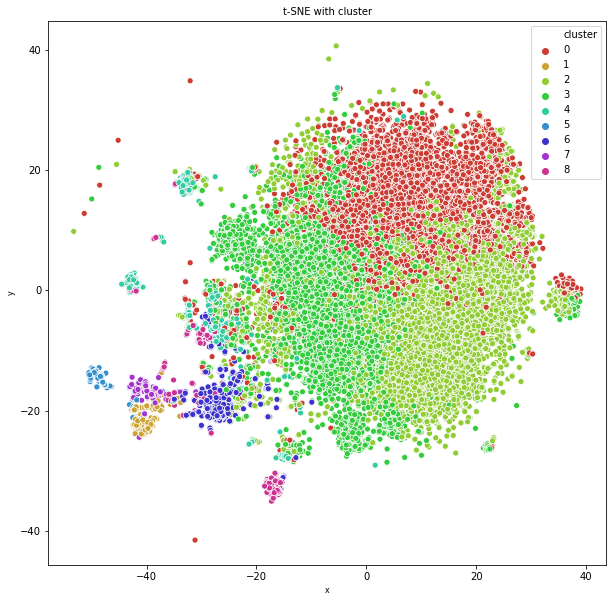

In [47]:
plt.figure(figsize=(10,10))
palette=sns.hls_palette(9,l=0.5,s=0.6)
sns.scatterplot(train_feat_embedded[:,0],train_feat_embedded[:,1],hue=train_feat_cluster['cluster'],palette=palette)
plt.title("t-SNE with cluster",fontsize=10)
plt.xlabel('x',fontsize=8)
plt.ylabel('y',fontsize=8)


Here are my interpretations,
* There is a non-linear separation boundary between each clusters.K-means and t-SNE seem to agree on the points used for separation though there are a few points where the clusters are different.
* Cluster 2 & 3 form a large portion of the gene expression data.



#### To do:
* The above cluster info could be used as a feature in our original dataset along with the other features and see if there is any improvement in scores.

* Use the clusters to check if we are able to differentiate between the class names as mentioned by [Andrea Zaliani](https://www.kaggle.com/headsortails/explorations-of-action-moa-eda/comments).

**Work in progress**